Example 6.6: Cliff Walking This gridworld example compares Sarsa and Q-learning,
highlighting the difference between on-policy (Sarsa) and off-policy (Q-learning) methods.
Consider the gridworld shown to the
right. This is a standard undiscounted, episodic task, with start
and goal states, and the usual actions causing movement up, down,
right, and left. Reward is 1 on all
transitions except those into the region marked “The Cliff” Stepping
into this region incurs a reward of
100 and sends the agent instantly
back to the start.
The graph to the right shows the
performance of the Sarsa and Qlearning methods with "-greedy action selection, " = 0.1. After an
initial transient, Q-learning learns
values for the optimal policy, that
which travels right along the edge
of the cliff. Unfortunately, this results in its occasionally falling off
the cliff because of the "-greedy action selection. Sarsa, on the other
hand, takes the action selection into
account and learns the longer but
safer path through the upper part
of the grid. Although Q-learning actually learns the values of the optimal policy, its online performance
is worse than that of Sarsa, which
learns the roundabout policy. Of course, if " were gradually reduced, then both methods
would asymptotically converge to the optimal policy.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

ROWS = 4
COLS = 12
T_STATE = (3, 11)

def get_next_state_and_reward(state, action):
    row, col = state
    if action == "left":
        new_pos = (row, col - 1)
    elif action == "right":
        new_pos = (row, col + 1)
    elif action == "up":
        new_pos = (row - 1, col)
    elif action == "down":
        new_pos = (row + 1, col)
    
    new_pos = (max(0, min(ROWS - 1, new_pos[0])), max(0, min(COLS - 1, new_pos[1])))

    if new_pos == T_STATE:
        reward = -1 # not sure if this is correct
    elif new_pos[0] == 3 and new_pos[1] >= 1 and new_pos[1] <= 10:
        reward = -100
        new_pos = (3, 0)
    else:
        reward = -1

    return new_pos, reward

def random_argmax(actions, q):
    best_val = max(q[a] for a in actions)
    best = [a for a in actions if q[a] == best_val]
    return np.random.choice(best)

def get_next_action(state, action_values, epsilon=0.1):
    available_actions = []
    if state[0] > 0:
        available_actions.append("up")
    if state[0] < ROWS - 1:
        available_actions.append("down")
    if state[1] > 0:
        available_actions.append("left")
    if state[1] < COLS - 1:
        available_actions.append("right")

    if np.random.random() < epsilon:
        return np.random.choice(available_actions)
    else:
        return random_argmax(available_actions, action_values[state[0]][state[1]])


INITIAL_STATE_ACTION_VALUES = [[{
    "left": 0,
    "right": 0,
    "up": 0,
    "down": 0
} for _ in range(COLS)] for _ in range(ROWS)]

In [22]:
import copy

def train_sarsa(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=500,
    decay_steps=None
):
    state_action_values = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    episode_rewards = []  # Track sum of rewards per episode
    for i in range(episodes):
        state = (3, 0)
        action = get_next_action(state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
        current_episode_reward = 0  # Sum of rewards for this episode
        while state != T_STATE:
            next_state, reward = get_next_state_and_reward(state, action)

            step_episodes.append(i)
            current_episode_reward += reward 

            next_action = get_next_action(next_state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            state_action_values[state[0]][state[1]][action] += alpha * (reward + state_action_values[next_state[0]][next_state[1]][next_action] - state_action_values[state[0]][state[1]][action])
            state = next_state
            action = next_action
        
        episode_rewards.append(current_episode_reward)

    return state_action_values, step_episodes, episode_rewards

def train_q_learning(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=500,
    decay_steps=None,
    max_steps=float('inf')
):
    state_action_values = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    episode_rewards = []  # Track sum of rewards per episode
    for i in range(episodes):
        state = (3, 0)
        current_episode_reward = 0  # Sum of rewards for this episode
        step = 0
        while state != T_STATE and step < max_steps:
            step += 1
            
            action = get_next_action(state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            next_state, r = get_next_state_and_reward(state, action)

            step_episodes.append(i)
            current_episode_reward += r  # Accumulate episode reward

            max_action_value = get_max_action_value(next_state, state_action_values)
            state_action_values[state[0]][state[1]][action] += alpha * (r + max_action_value - state_action_values[state[0]][state[1]][action])
            state = next_state
        
        episode_rewards.append(current_episode_reward)  # Store episode total

    return state_action_values, step_episodes, episode_rewards

def get_max_action_value(state, state_action_values):
    if state == T_STATE:
        return 0
    else:
        values = [value for key, value in state_action_values[state[0]][state[1]].items()]
        return max(values)

def get_epsilon(episode, initial_eps=.1, final_eps=0.001, decay_steps=150):
    if episode >= decay_steps:
        return final_eps
    return initial_eps - (initial_eps - final_eps) * (episode / decay_steps)

def generate_episode(state_action_values, epsilon=0.1):
    state = (3, 0)
    episode = [state]
    while state != T_STATE:
        action = get_next_action(state, state_action_values, epsilon)
        state, reward = get_next_state_and_reward(state, action)
        episode.append(state)
    
    return episode

def plot_episode(state_action_values, epsilon=0.1):
    episode_path = generate_episode(state_action_values, epsilon)
    print(len(episode_path))

    cols = [pos[1] for pos in episode_path]
    rows = [pos[0] for pos in episode_path]

    # Simple plot with dots
    plt.figure(figsize=(7, 3))
    plt.plot(cols, rows, 'o-', markersize=8, linewidth=2, label='Episode path')
    
    # Mark start and goal states
    plt.plot(0, 3, 's', markersize=12, color='green', label='Start (3,0)')
    plt.plot(11, 3, '*', markersize=15, color='red', label='Goal (3,11)')
    
    plt.xlim(-0.5, COLS - 0.5)  # 0 to 9 for columns
    plt.ylim(-0.5, ROWS - 0.5)  # 0 to 6 for rows
    
    # Add grid and formatting
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()  # Flip y-axis so row 0 is at top
    
    # Add axis labels and title
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    
    # Set integer ticks for better grid visualization
    plt.xticks(range(COLS))
    plt.yticks(range(ROWS))
    
    plt.tight_layout()
    plt.show()

329062


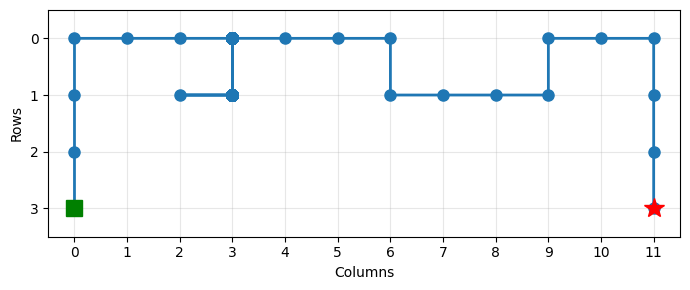

In [23]:
sarsa_state_action_values, sarsa_step_episodes, sarsa_episode_rewards = train_sarsa(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=500
)
plot_episode(sarsa_state_action_values, epsilon=0.00001)

436


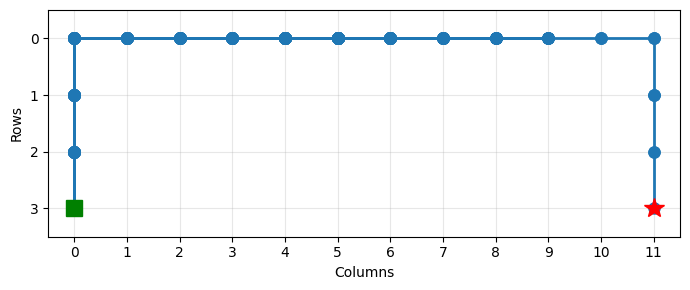

In [24]:
q_state_action_values, q_step_episodes, q_episode_rewards = train_q_learning(
    INITIAL_STATE_ACTION_VALUES,
    alpha=0.5,
    epsilon=0.1,
    episodes=500
)
plot_episode(q_state_action_values, epsilon=0.00001)

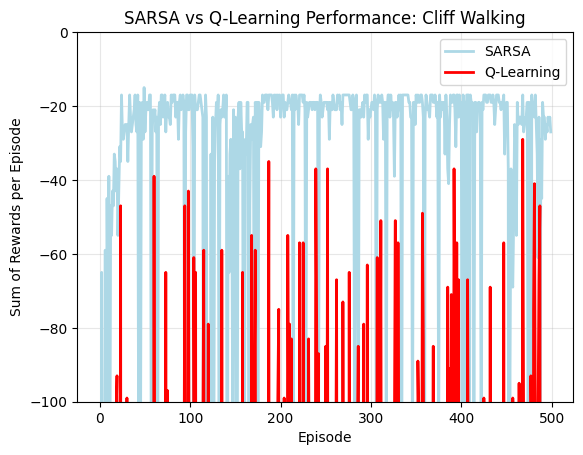

In [25]:
plt.plot(sarsa_episode_rewards, color='lightblue', label='SARSA', linewidth=2)
plt.plot(q_episode_rewards, color='red', label='Q-Learning', linewidth=2)

# limit y axis to -100 to 0
plt.ylim(-100, 0)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards per Episode')
plt.title('SARSA vs Q-Learning Performance: Cliff Walking')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()